In [42]:
import pandas as pd
import numpy as np
import xgboost as xgb
 
import pickle
from geopy.geocoders import Nominatim
from sklearn.model_selection import train_test_split
 
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

train = '/content/drive/My Drive/data/train.csv'
test = '/content/drive/My Drive/data/test.csv'

# Import data and take a look at it

In [5]:
sample_df = pd.read_csv(train)

In [6]:
sample_df.shape

(1458644, 11)

In [7]:
sample_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


# Data Preprocessing

In [8]:
sample_df["store_and_fwd_flag"].value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

In [9]:
#Convert character variables to numeric 
f = lambda x: 0 if x == 'N' else 1

sample_df["store_and_fwd_flag"] = sample_df["store_and_fwd_flag"].apply(lambda x: f(x))            

In [10]:
#Check result
sample_df["store_and_fwd_flag"].value_counts()

0    1450599
1       8045
Name: store_and_fwd_flag, dtype: int64

## Engineer features

In [11]:
#First, convert datetime strings into datetime
sample_df["dropoff_datetime"] = pd.to_datetime(sample_df["dropoff_datetime"], format='%Y-%m-%d %H:%M:%S')
sample_df["pickup_datetime"] = pd.to_datetime(sample_df["pickup_datetime"], format='%Y-%m-%d %H:%M:%S')

In [12]:
#Now construct other variables, like month, date, etc.
sample_df["pickup_month"] = sample_df["pickup_datetime"].dt.month
sample_df["pickup_day"] = sample_df["pickup_datetime"].dt.day
sample_df["pickup_weekday"] = sample_df["pickup_datetime"].dt.weekday #sample_df["pickup_weekday"] = sample_df["pickup_datetime"].dt.weekday_name
sample_df["pickup_hour"] = sample_df["pickup_datetime"].dt.hour
sample_df["pickup_minute"] = sample_df["pickup_datetime"].dt.minute

In [13]:
#Get latitude and longitude differences 
sample_df["latitude_difference"] = sample_df["dropoff_latitude"] - sample_df["pickup_latitude"]
sample_df["longitude_difference"] = sample_df["dropoff_longitude"] - sample_df["pickup_longitude"]

In [14]:
#Convert duration to minutes for easier interpretation
sample_df["trip_duration"] = sample_df["trip_duration"].apply(lambda x: round(x/60))   

In [15]:
#Convert trip distance from longitude and latitude differences to Manhattan distance.
sample_df["trip_distance"] = 0.621371 * 6371 * (abs(2 * np.arctan2(np.sqrt(np.square(np.sin((abs(sample_df["latitude_difference"]) * np.pi / 180) / 2))), 
                                  np.sqrt(1-(np.square(np.sin((abs(sample_df["latitude_difference"]) * np.pi / 180) / 2)))))) + \
                                     abs(2 * np.arctan2(np.sqrt(np.square(np.sin((abs(sample_df["longitude_difference"]) * np.pi / 180) / 2))), 
                                  np.sqrt(1-(np.square(np.sin((abs(sample_df["longitude_difference"]) * np.pi / 180) / 2)))))))

In [16]:
sample_df.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_month,pickup_day,pickup_weekday,pickup_hour,pickup_minute,latitude_difference,longitude_difference,trip_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,8,3,14,0,17,24,-0.002335,0.017525,1.372146
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,11,6,12,6,0,43,-0.007412,-0.019066,1.829440
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,35,1,19,1,11,35,-0.053852,-0.026306,5.538397
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,7,4,6,2,19,32,-0.013252,-0.002228,1.069567
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,7,3,26,5,13,30,-0.010689,0.000130,0.747485


# Modeling

In [17]:
X = sample_df.drop(["trip_duration", "id", "vendor_id", "pickup_datetime", "dropoff_datetime"], axis=1)
y = sample_df["trip_duration"]

In [18]:
#Split the data into training, test, and valdiation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2018)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2019)

In [19]:
#Define evaluation metric
def rmsle(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean() ** 0.5

In [20]:
#XGBoost parameters 
params = {
    'booster':            'gbtree',
    'objective':          'reg:linear',
    'learning_rate':      0.05,
    'max_depth':          14,
    'subsample':          0.9,
    'colsample_bytree':   0.7,
    'colsample_bylevel':  0.7,
    'silent':             1,
    'feval':              'rmsle'
}

In [21]:
nrounds = 2000

In [22]:
#Define train and validation sets
dtrain = xgb.DMatrix(X_train, np.log(y_train+1))
dval = xgb.DMatrix(X_val, np.log(y_val+1))

#this is for tracking the error
watchlist = [(dval, 'eval'), (dtrain, 'train')]

In [23]:
#Train model
gbm = xgb.train(params,
                dtrain,
                num_boost_round = nrounds,
                evals = watchlist,
                verbose_eval = True
                )

[0]	eval-rmse:2.00789	train-rmse:2.00723
[1]	eval-rmse:1.91382	train-rmse:1.91301
[2]	eval-rmse:1.8224	train-rmse:1.82168
[3]	eval-rmse:1.73564	train-rmse:1.73493
[4]	eval-rmse:1.65361	train-rmse:1.6529
[5]	eval-rmse:1.57611	train-rmse:1.57535
[6]	eval-rmse:1.50257	train-rmse:1.50186
[7]	eval-rmse:1.43242	train-rmse:1.43161
[8]	eval-rmse:1.36599	train-rmse:1.36504
[9]	eval-rmse:1.30344	train-rmse:1.30226
[10]	eval-rmse:1.24574	train-rmse:1.24447
[11]	eval-rmse:1.18978	train-rmse:1.18836
[12]	eval-rmse:1.13651	train-rmse:1.13491
[13]	eval-rmse:1.08712	train-rmse:1.08538
[14]	eval-rmse:1.0393	train-rmse:1.03722
[15]	eval-rmse:0.994316	train-rmse:0.992083
[16]	eval-rmse:0.951946	train-rmse:0.949297
[17]	eval-rmse:0.912964	train-rmse:0.909992
[18]	eval-rmse:0.874894	train-rmse:0.871421
[19]	eval-rmse:0.839132	train-rmse:0.83537
[20]	eval-rmse:0.805413	train-rmse:0.80117
[21]	eval-rmse:0.773894	train-rmse:0.768976
[22]	eval-rmse:0.745075	train-rmse:0.73971
[23]	eval-rmse:0.717028	train-rmse

In [24]:
#Test predictions
pred = np.exp(gbm.predict(xgb.DMatrix(X_test))) - 1

In [26]:
#Use mean absolute error to get a basic estimate of the error
mae = (abs(pred - y_test)).mean()
mae

4.822598457336426

In [27]:
#Take a look at feature importance
feature_scores = gbm.get_fscore()
feature_scores

{'dropoff_latitude': 644400,
 'dropoff_longitude': 652486,
 'latitude_difference': 461600,
 'longitude_difference': 479637,
 'passenger_count': 234694,
 'pickup_day': 381195,
 'pickup_hour': 338569,
 'pickup_latitude': 771064,
 'pickup_longitude': 803758,
 'pickup_minute': 391020,
 'pickup_month': 226184,
 'pickup_weekday': 225558,
 'store_and_fwd_flag': 5481,
 'trip_distance': 456990}

In [28]:
#This is not very telling, so let's scale the features
summ = 0
for key in feature_scores:
    summ = summ + feature_scores[key]

for key in feature_scores:
    feature_scores[key] = feature_scores[key] / summ

feature_scores

{'dropoff_latitude': 0.10611536736270707,
 'dropoff_longitude': 0.10744691432188591,
 'latitude_difference': 0.07601311852052386,
 'longitude_difference': 0.07898332783325067,
 'passenger_count': 0.038647796442928574,
 'pickup_day': 0.06277257520457344,
 'pickup_hour': 0.05575321820705209,
 'pickup_latitude': 0.12697352517094718,
 'pickup_longitude': 0.13235734860446105,
 'pickup_minute': 0.06439048874327392,
 'pickup_month': 0.037246428075056695,
 'pickup_weekday': 0.03714334269335425,
 'store_and_fwd_flag': 0.000902573445864366,
 'trip_distance': 0.07525397537412089}

# Save the model

In [29]:
filename = "xgb_model.sav"
pickle.dump(gbm, open(filename, 'wb'))

# Genetic Algorithm

In [30]:
import pandas as pd
import numpy as np
import xgboost as xgb

from copy import copy
import datetime
import pickle
from geopy.geocoders import Nominatim



In [31]:
filename = "xgb_model.sav"

In [32]:
# Open saved model
loaded_model = pickle.load(open(filename, 'rb'))

In [33]:
#genetic Algorithm
#Sample test locations
#Sample date

date_list = [4, 6, 2016] #April 6, 2016

year = int(date_list[2])
month = int(date_list[1])
day = int(date_list[0])

my_date = datetime.date(year, month, day)

In [34]:


test_locations = {'L1': (40.819688, -73.915091),
                  'L2': (40.815421, -73.941761),
                  'L3': (40.764198, -73.910785),
                  'L4': (40.768790, -73.953285),
                  'L5': (40.734851, -73.952950),
                  'L6': (40.743613, -73.977998),
                  'L7': (40.745313, -73.993793),
                  'L8': (40.662713, -73.946101),
                  'L9': (40.703761, -73.886496),
                  'L10': (40.713620, -73.943076),
                  'L11': (40.725212, -73.809179)
             }

In [35]:
geolocator = Nominatim()
addresses = []

for key in test_locations:
    location = geolocator.reverse(test_locations[key])
    addresses.append(location.address)

/usr/local/lib/python3.7/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


In [37]:
addresses

['424, East 155th Street, The Bronx, Bronx County, New York, 10455, United States',
 '137, West 136th Street, Harlem, Manhattan Community Board 10, Manhattan, New York County, New York, 10030, United States',
 '43-11, 28th Avenue, Queens, Queens County, New York, 11103, United States',
 '435, East 74th Street, Upper East Side, Manhattan Community Board 8, Manhattan, New York County, New York, 10021, United States',
 '211, Freeman Street, Brooklyn, Kings County, New York, 11222, United States',
 '232, East 32nd Street, Kips Bay, Manhattan Community Board 6, Manhattan, New York County, New York, 10016, United States',
 '159, West 25th Street, Flatiron District, Manhattan Community Board 5, Manhattan, New York County, New York, 10001, United States',
 '458, Lefferts Avenue, Crown Heights, Brooklyn, Kings County, New York, 11225, United States',
 '70-38, 67th Place, Glendale, Queens, Queens County, New York, 11385, United States',
 '194, Devoe Street, Williamsburg, Brooklyn, Kings County, 

In [38]:
test_addresses = {'L1': '424 East 155th Street NY',
                  'L2': '137 West 136th Street NY',
                  'L3': '43-11 28th Avenue NY',
                  'L4': '435 East 74th Street NY',
                  'L5': '211 Freeman Street NY',
                  'L6': '232 East 32nd Street NY',
                  'L7': '159 West 25th Street NY',
                  'L8': '486 Brooklyn Avenue NY',
                  'L9': '70-38 67th Place NY',
                  'L10': '194 Devoe Street NY',
                  'L11': '158-46 76th Avenue NY'
             }

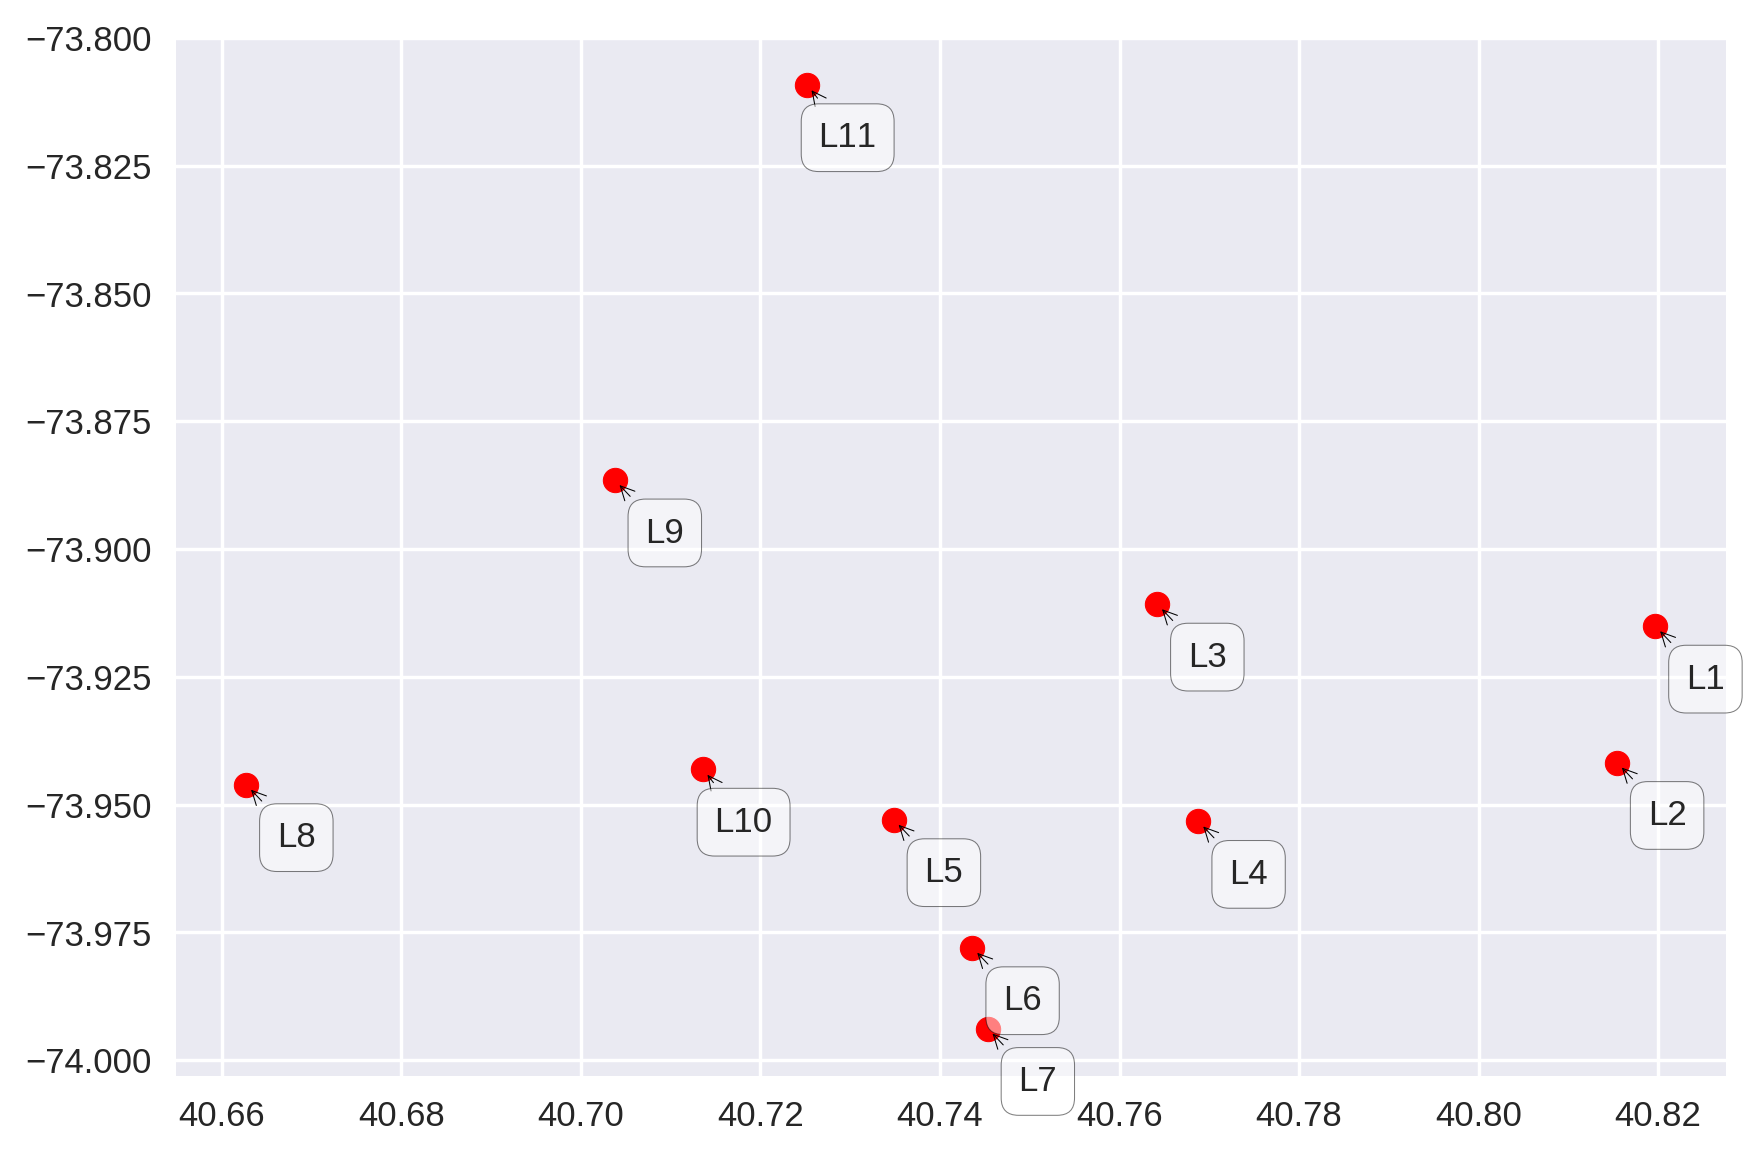

In [43]:
def plot_locations(test_locations, annotate=True):
    """
    Makes a plot of all locations.
    Input: test_locations; dictionary of all cities and their coordinates in (x,y) format
    """
    names = []
    x = []
    y = []
    plt.figure(dpi=250)
    for ix, coord in test_locations.items():
        names.append(ix)
        x.append(coord[0])
        y.append(coord[1])
        if annotate:
            plt.annotate(ix, xy=(coord[0], coord[1]), xytext=(20, -20),
                        textcoords='offset points', ha='right', va='bottom',
                        bbox=dict(boxstyle='round,pad=0.5', fc='w', alpha=0.5),
                        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    plt.scatter(x,y,c='r',marker='o')
            
plot_locations(test_locations)

In [46]:
def create_guess(points):
    """
    Creates a possible path between all points, returning to the original.
    Input: List of point IDs
    """
    guess = copy(points)
    np.random.shuffle(guess)
    guess.append(guess[0])
    return list(guess)

create_guess(list(test_locations.keys()))

['L8', 'L1', 'L10', 'L11', 'L4', 'L7', 'L6', 'L3', 'L9', 'L2', 'L5', 'L8']

['L2', 'L8', 'L9', 'L11', 'L4', 'L6', 'L3', 'L1', 'L7', 'L5', 'L10', 'L2']


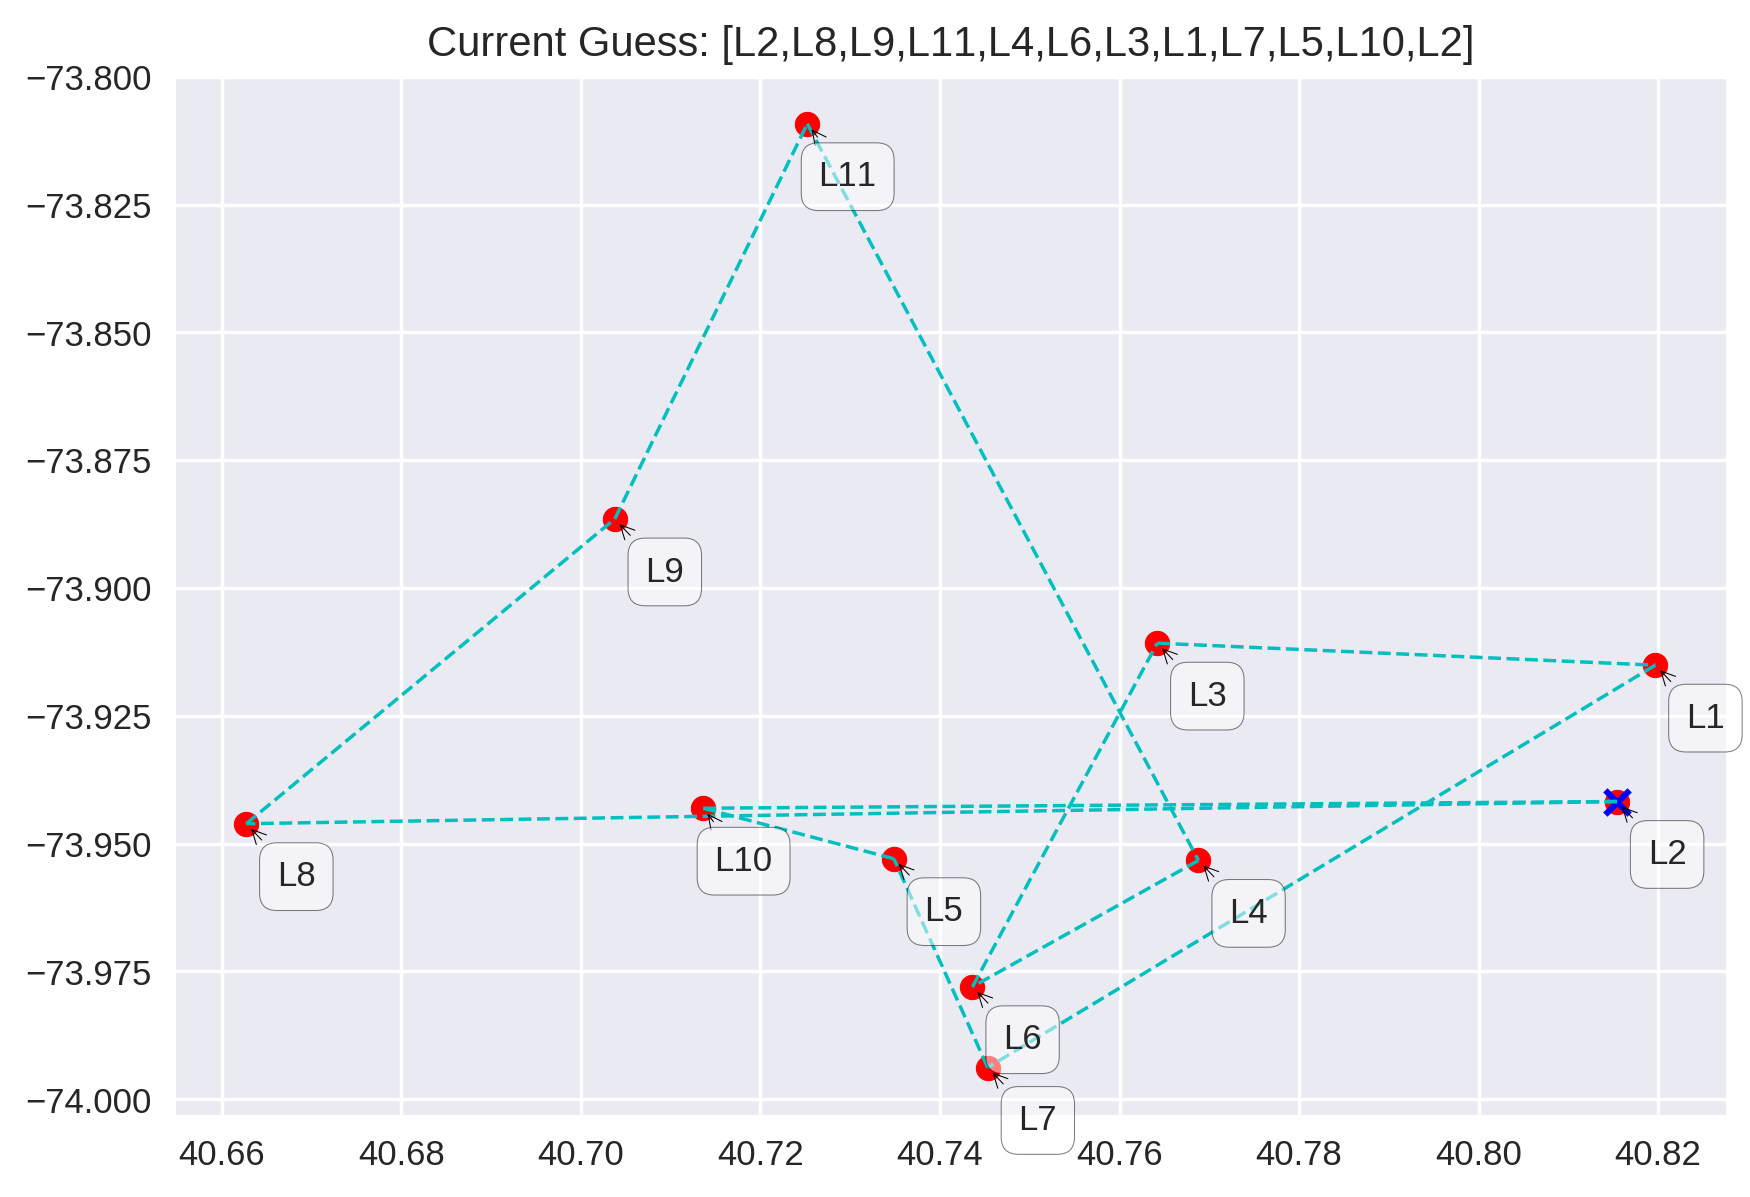

In [47]:
def plot_guess(test_locations, guess, guess_in_title=True):
    """
    Takes the coordinates of the locations and the guessed path and
    makes a plot connecting the locations in the guessed order
    Input:
    city_coordinate: dictionary of location id, (x,y)
    guess: list of ids in order
    """
    plot_locations(test_locations)
    for ix, current_city in enumerate(guess[:-1]):
        x = [test_locations[guess[ix]][0],test_locations[guess[ix+1]][0]]
        y = [test_locations[guess[ix]][1],test_locations[guess[ix+1]][1]]
        plt.plot(x,y,'c--',lw=1)
    plt.scatter(test_locations[guess[0]][0],test_locations[guess[0]][1], marker='x', c='b')   
    if guess_in_title:
        plt.title("Current Guess: [%s]"%(','.join([str(x) for x in guess])))
    else:
        print("Current Guess: [%s]"%(','.join([str(x) for x in guess])))
    
path = create_guess(list(test_locations.keys()))
print(path)
plot_guess(test_locations, path)

In [50]:
def create_generation(points, population=100):
    """
    Makes a list of guessed point orders given a list of point IDs.
    Input:
    points: list of point ids
    population: how many guesses to make
    """
    generation = [create_guess(points) for _ in range(population)]
    return generation

test_generation = create_generation(list(test_locations.keys()), population=10)
print(test_generation)

[['L4', 'L6', 'L10', 'L3', 'L1', 'L2', 'L7', 'L11', 'L5', 'L9', 'L8', 'L4'], ['L10', 'L5', 'L3', 'L7', 'L1', 'L4', 'L2', 'L11', 'L8', 'L9', 'L6', 'L10'], ['L11', 'L7', 'L3', 'L10', 'L8', 'L2', 'L4', 'L9', 'L6', 'L5', 'L1', 'L11'], ['L8', 'L11', 'L5', 'L4', 'L2', 'L3', 'L7', 'L1', 'L6', 'L9', 'L10', 'L8'], ['L6', 'L1', 'L2', 'L11', 'L9', 'L3', 'L5', 'L7', 'L8', 'L4', 'L10', 'L6'], ['L2', 'L4', 'L11', 'L7', 'L6', 'L8', 'L9', 'L5', 'L3', 'L1', 'L10', 'L2'], ['L1', 'L6', 'L2', 'L3', 'L11', 'L10', 'L7', 'L5', 'L8', 'L4', 'L9', 'L1'], ['L4', 'L2', 'L3', 'L8', 'L6', 'L5', 'L7', 'L11', 'L9', 'L10', 'L1', 'L4'], ['L11', 'L1', 'L5', 'L10', 'L7', 'L2', 'L3', 'L8', 'L4', 'L9', 'L6', 'L11'], ['L6', 'L11', 'L1', 'L9', 'L2', 'L3', 'L5', 'L8', 'L10', 'L7', 'L4', 'L6']]


In [51]:
def travel_time_between_points(point1_id, point2_id, hour, date, passenger_count = 1, 
                               store_and_fwd_flag = 0, pickup_minute = 0):
    """
    Given two points, this calculates travel between them based on a XGBoost predictive model
    """
    
    model_data = {'passenger_count': passenger_count,
                  'pickup_longitude' : point1_id[1],
                  'pickup_latitude' : point1_id[0],
                  'dropoff_longitude' : point2_id[1],
                  'dropoff_latitude' : point2_id[0],
                  'store_and_fwd_flag' : store_and_fwd_flag,
                  'pickup_month' : my_date.month,
                  'pickup_day' : my_date.day,
                  'pickup_weekday' : my_date.weekday(),
                  'pickup_hour': hour,
                  'pickup_minute' : pickup_minute,
                  'latitude_difference' : point2_id[0] - point1_id[0],
                  'longitude_difference' : point2_id[1] - point1_id[1],
                  'trip_distance' : 0.621371 * 6371 * (abs(2 * np.arctan2(np.sqrt(np.square(np.sin((abs(point2_id[0] - point1_id[0]) * np.pi / 180) / 2))), 
                                  np.sqrt(1-(np.square(np.sin((abs(point2_id[0] - point1_id[0]) * np.pi / 180) / 2)))))) + \
                                     abs(2 * np.arctan2(np.sqrt(np.square(np.sin((abs(point2_id[1] - point1_id[1]) * np.pi / 180) / 2))), 
                                  np.sqrt(1-(np.square(np.sin((abs(point2_id[1] - point1_id[1]) * np.pi / 180) / 2)))))))
                 }

    df = pd.DataFrame([model_data], columns=model_data.keys())
    
    pred = np.exp(loaded_model.predict(xgb.DMatrix(df))) - 1
    
    return pred[0]

In [52]:
coordinates = test_locations

In [53]:
def fitness_score(guess):
    """
    Loops through the points in the guesses order and calculates
    how much distance the path would take to complete a loop.
    Lower is better.
    """
    score = 0
    for ix, point_id in enumerate(guess[:-1]):
        score += travel_time_between_points(coordinates[point_id], coordinates[guess[ix+1]], 11, my_date)
    return score

def check_fitness(guesses):
    """
    Goes through every guess and calculates the fitness score. 
    Returns a list of tuples: (guess, fitness_score)
    """
    fitness_indicator = []
    for guess in guesses:
        fitness_indicator.append((guess, fitness_score(guess)))
    return fitness_indicator

print(check_fitness(test_generation))

[(['L4', 'L6', 'L10', 'L3', 'L1', 'L2', 'L7', 'L11', 'L5', 'L9', 'L8', 'L4'], 262.01058769226074), (['L10', 'L5', 'L3', 'L7', 'L1', 'L4', 'L2', 'L11', 'L8', 'L9', 'L6', 'L10'], 263.1548652648926), (['L11', 'L7', 'L3', 'L10', 'L8', 'L2', 'L4', 'L9', 'L6', 'L5', 'L1', 'L11'], 280.86310863494873), (['L8', 'L11', 'L5', 'L4', 'L2', 'L3', 'L7', 'L1', 'L6', 'L9', 'L10', 'L8'], 279.85132217407227), (['L6', 'L1', 'L2', 'L11', 'L9', 'L3', 'L5', 'L7', 'L8', 'L4', 'L10', 'L6'], 275.61453437805176), (['L2', 'L4', 'L11', 'L7', 'L6', 'L8', 'L9', 'L5', 'L3', 'L1', 'L10', 'L2'], 282.35526847839355), (['L1', 'L6', 'L2', 'L3', 'L11', 'L10', 'L7', 'L5', 'L8', 'L4', 'L9', 'L1'], 289.34948539733887), (['L4', 'L2', 'L3', 'L8', 'L6', 'L5', 'L7', 'L11', 'L9', 'L10', 'L1', 'L4'], 268.66258335113525), (['L11', 'L1', 'L5', 'L10', 'L7', 'L2', 'L3', 'L8', 'L4', 'L9', 'L6', 'L11'], 288.84695053100586), (['L6', 'L11', 'L1', 'L9', 'L2', 'L3', 'L5', 'L8', 'L10', 'L7', 'L4', 'L6'], 258.0133247375488)]


In [55]:
def get_breeders_from_generation(guesses, take_best_N=10, take_random_N=5, verbose=False, mutation_rate=0.1):
    """
    This sets up the breeding group for the next generation. You have
    to be very careful how many breeders you take, otherwise your
    population can explode. These two, plus the "number of children per couple"
    in the make_children function must be tuned to avoid exponential growth or decline!
    """
    # First, get the top guesses from last time
    fit_scores = check_fitness(guesses)
    sorted_guesses = sorted(fit_scores, key=lambda x: x[1]) # sorts so lowest is first, which we want
    new_generation = [x[0] for x in sorted_guesses[:take_best_N]]
    best_guess = new_generation[0]
    
    if verbose:
        # If we want to see what the best current guess is!
        print(best_guess)
    
    # Second, get some random ones for genetic diversity
    for _ in range(take_random_N):
        ix = np.random.randint(len(guesses))
        new_generation.append(guesses[ix])
        
    # No mutations here since the order really matters.
    # If we wanted to, we could add a "swapping" mutation,
    # but in practice it doesn't seem to be necessary
    
    np.random.shuffle(new_generation)
    return new_generation, best_guess

def make_child(parent1, parent2):
    """ 
    Take some values from parent 1 and hold them in place, then merge in values
    from parent2, filling in from left to right with cities that aren't already in 
    the child. 
    """
    list_of_ids_for_parent1 = list(np.random.choice(parent1, replace=False, size=len(parent1)//2))
    child = [-99 for _ in parent1]
    
    for ix in range(0, len(list_of_ids_for_parent1)):
        child[ix] = parent1[ix]
    for ix, gene in enumerate(child):
        if gene == -99:
            for gene2 in parent2:
                if gene2 not in child:
                    child[ix] = gene2
                    break
    child[-1] = child[0]
    return child

def make_children(old_generation, children_per_couple=1):
    """
    Pairs parents together, and makes children for each pair. 
    If there are an odd number of parent possibilities, one 
    will be left out. 
    
    Pairing happens by pairing the first and last entries. 
    Then the second and second from last, and so on.
    """
    mid_point = len(old_generation)//2
    next_generation = [] 
    
    for ix, parent in enumerate(old_generation[:mid_point]):
        for _ in range(children_per_couple):
            next_generation.append(make_child(parent, old_generation[-ix-1]))
    return next_generation

In [56]:
current_generation = create_generation(list(test_locations.keys()),population=500)
print_every_n_generations = 5

for i in range(100):
    if not i % print_every_n_generations:
        print("Generation %i: "%i, end='')
        print(len(current_generation))
        is_verbose = True
    else:
        is_verbose = False
    breeders, best_guess = get_breeders_from_generation(current_generation, 
                                                        take_best_N=250, take_random_N=100, 
                                                        verbose=is_verbose)
    current_generation = make_children(breeders, children_per_couple=3)

Generation 0: 500
['L4', 'L3', 'L9', 'L10', 'L11', 'L8', 'L2', 'L1', 'L7', 'L6', 'L5', 'L4']
Generation 5: 525
['L4', 'L3', 'L9', 'L10', 'L11', 'L8', 'L5', 'L6', 'L7', 'L2', 'L1', 'L4']
Generation 10: 525
['L2', 'L3', 'L9', 'L5', 'L10', 'L8', 'L11', 'L6', 'L7', 'L4', 'L1', 'L2']
Generation 15: 525
['L11', 'L9', 'L10', 'L8', 'L4', 'L1', 'L2', 'L3', 'L5', 'L6', 'L7', 'L11']
Generation 20: 525
['L11', 'L9', 'L10', 'L8', 'L4', 'L1', 'L2', 'L3', 'L5', 'L6', 'L7', 'L11']
Generation 25: 525
['L11', 'L9', 'L10', 'L8', 'L4', 'L1', 'L2', 'L3', 'L5', 'L6', 'L7', 'L11']
Generation 30: 525
['L11', 'L9', 'L10', 'L8', 'L4', 'L1', 'L2', 'L3', 'L5', 'L6', 'L7', 'L11']
Generation 35: 525
['L11', 'L9', 'L10', 'L8', 'L4', 'L1', 'L2', 'L3', 'L5', 'L6', 'L7', 'L11']
Generation 40: 525
['L11', 'L9', 'L10', 'L8', 'L4', 'L1', 'L2', 'L3', 'L5', 'L6', 'L7', 'L11']
Generation 45: 525
['L11', 'L9', 'L10', 'L8', 'L4', 'L1', 'L2', 'L3', 'L5', 'L6', 'L7', 'L11']
Generation 50: 525
['L11', 'L9', 'L10', 'L8', 'L4', 'L1

In [57]:
def evolve_to_solve(current_generation, max_generations, take_best_N, take_random_N,
                    mutation_rate, children_per_couple, print_every_n_generations, verbose=False):
    """
    Takes in a generation of guesses then evolves them over time using our breeding rules.
    Continue this for "max_generations" times.
    Inputs:
    current_generation: The first generation of guesses
    max_generations: how many generations to complete
    take_best_N: how many of the top performers get selected to breed
    take_random_N: how many random guesses get brought in to keep genetic diversity
    mutation_rate: How often to mutate (currently unused)
    children_per_couple: how many children per breeding pair
    print_every_n_geneartions: how often to print in verbose mode
    verbose: Show printouts of progress
    Returns:
    fitness_tracking: a list of the fitness score at each generations
    best_guess: the best_guess at the end of evolution
    """
    fitness_tracking = []
    for i in range(max_generations):
        if verbose and not i % print_every_n_generations and i > 0:
            print("Generation %i: "%i, end='')
            print(len(current_generation))
            print("Current Best Score: ", fitness_tracking[-1])
            is_verbose = True
        else:
            is_verbose = False
        breeders, best_guess = get_breeders_from_generation(current_generation, 
                                                            take_best_N=take_best_N, take_random_N=take_random_N, 
                                                            verbose=is_verbose, mutation_rate=mutation_rate)
        fitness_tracking.append(fitness_score(best_guess))
        current_generation = make_children(breeders, children_per_couple=children_per_couple)
    
    return fitness_tracking, best_guess

current_generation = create_generation(list(test_locations.keys()),population=500)
fitness_tracking, best_guess = evolve_to_solve(current_generation, 100, 150, 70, 0.5, 3, 5, verbose=True)

Generation 5: 330
Current Best Score:  212.0965061187744
['L9', 'L10', 'L7', 'L6', 'L4', 'L2', 'L1', 'L3', 'L5', 'L11', 'L8', 'L9']
Generation 10: 330
Current Best Score:  210.00734329223633
['L9', 'L10', 'L7', 'L6', 'L4', 'L2', 'L1', 'L3', 'L5', 'L11', 'L8', 'L9']
Generation 15: 330
Current Best Score:  213.85950183868408
['L11', 'L9', 'L2', 'L1', 'L3', 'L5', 'L6', 'L7', 'L4', 'L10', 'L8', 'L11']
Generation 20: 330
Current Best Score:  213.85950183868408
['L11', 'L9', 'L2', 'L1', 'L3', 'L5', 'L6', 'L7', 'L4', 'L10', 'L8', 'L11']
Generation 25: 330
Current Best Score:  213.85950183868408
['L11', 'L9', 'L2', 'L1', 'L3', 'L5', 'L6', 'L7', 'L4', 'L10', 'L8', 'L11']
Generation 30: 330
Current Best Score:  213.85950183868408
['L11', 'L9', 'L2', 'L1', 'L3', 'L5', 'L6', 'L7', 'L4', 'L10', 'L8', 'L11']
Generation 35: 330
Current Best Score:  213.85950183868408
['L11', 'L9', 'L2', 'L1', 'L3', 'L5', 'L6', 'L7', 'L4', 'L10', 'L8', 'L11']
Generation 40: 330
Current Best Score:  213.85950183868408


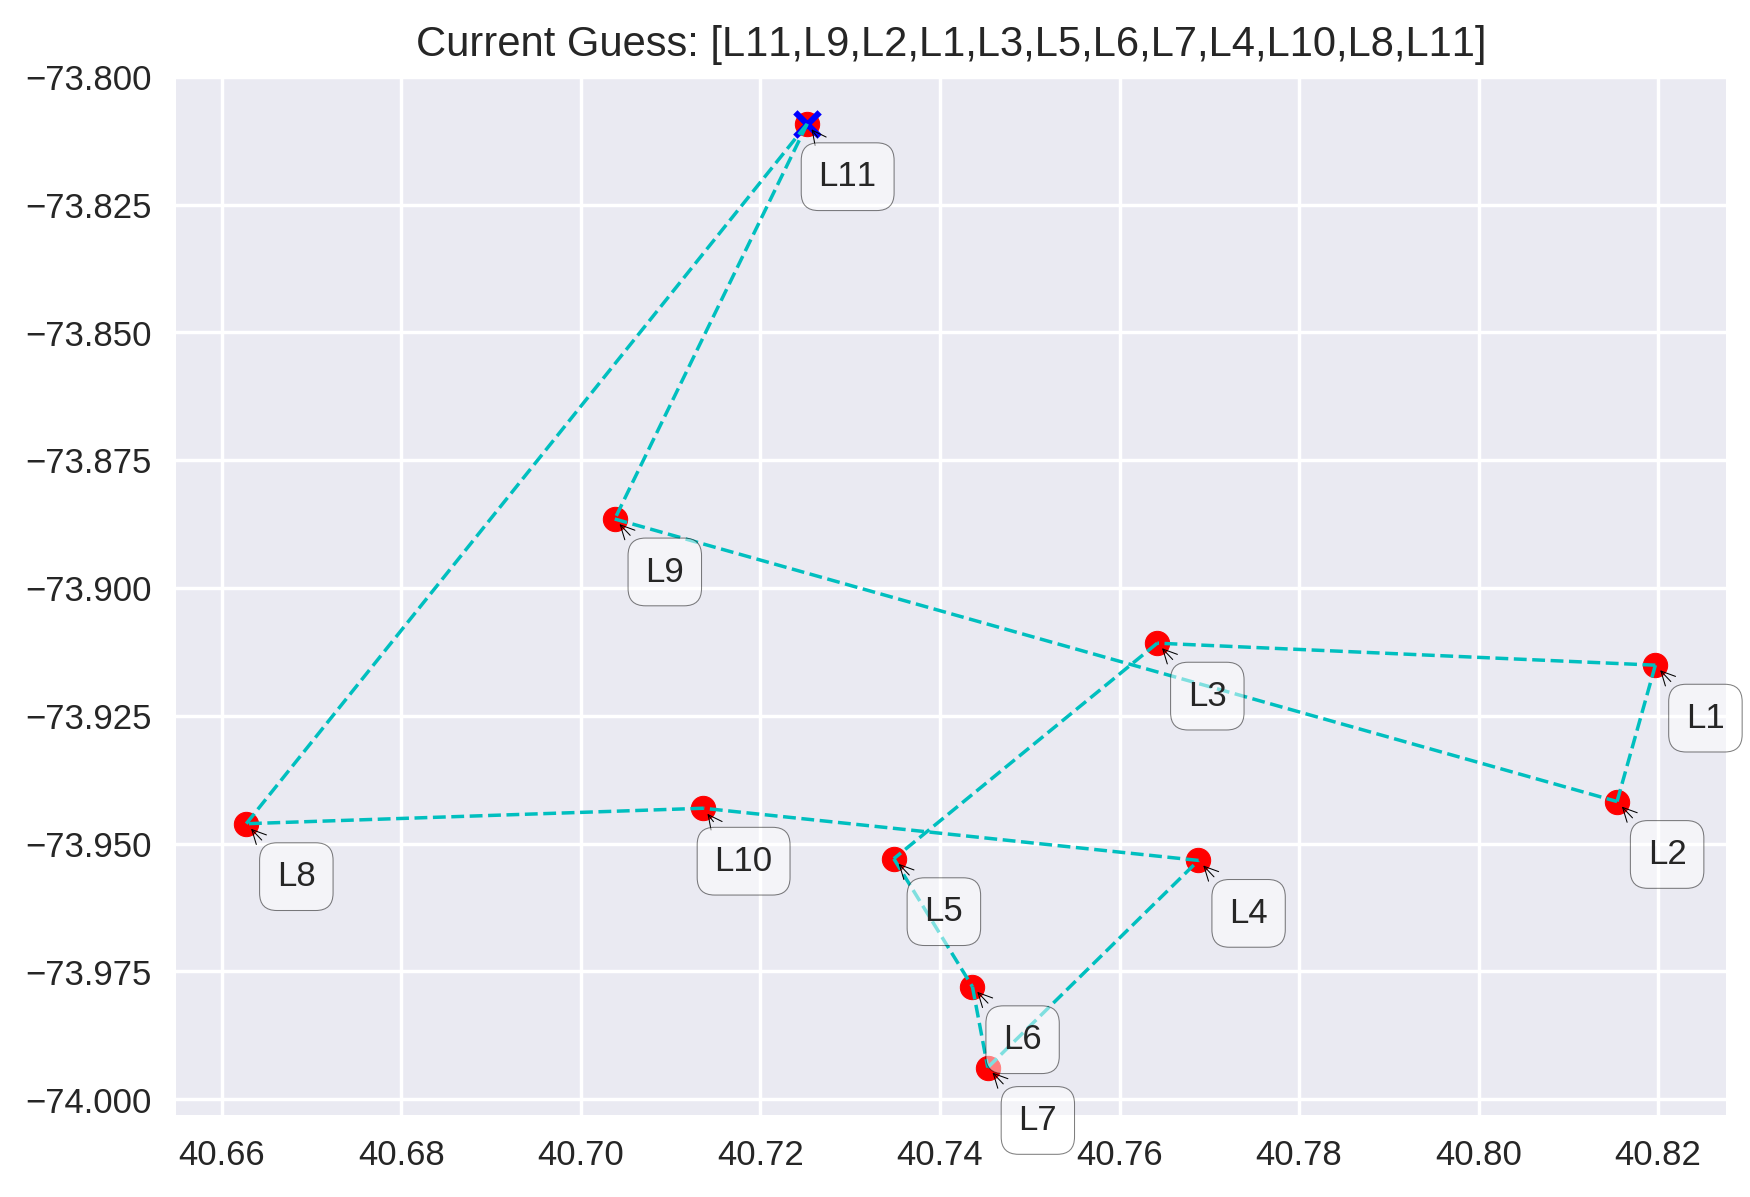

In [58]:
plot_guess(test_locations, best_guess)

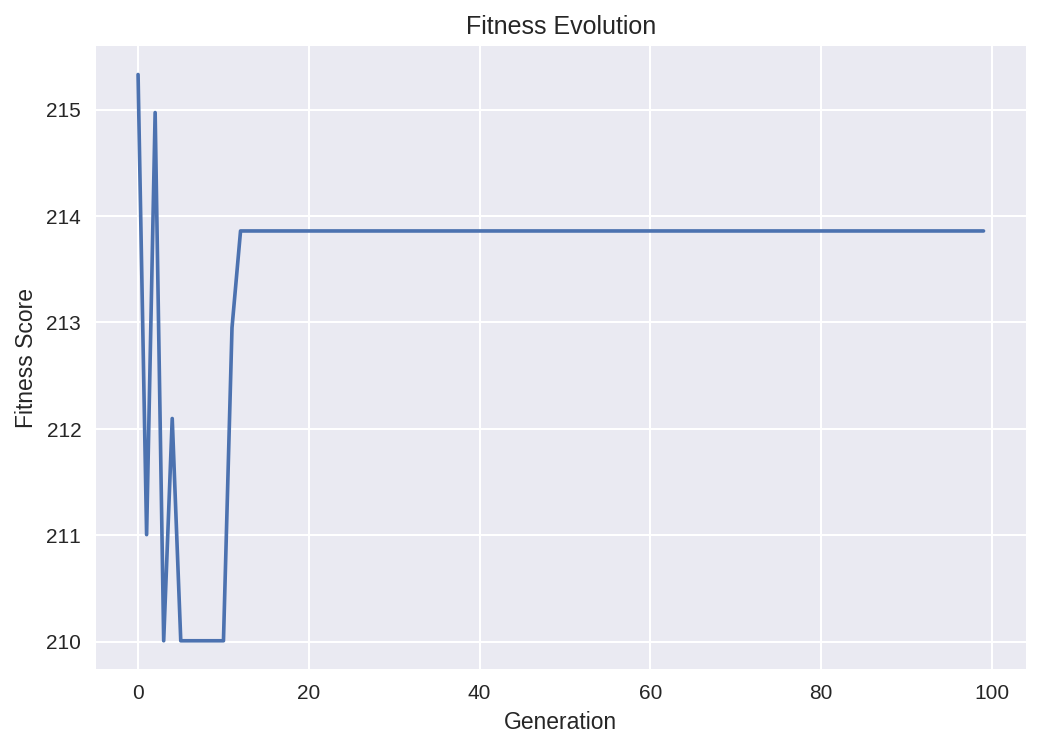

In [59]:
def make_fitness_tracking_plot(fitness_tracking):
    """
    Given a list of fitness scores, plot it versus the generation number
    """
    plt.figure(dpi=150)
    plt.plot(range(len(fitness_tracking)), fitness_tracking)
    plt.ylabel("Fitness Score")
    plt.xlabel("Generation")
    plt.title("Fitness Evolution");

make_fitness_tracking_plot(fitness_tracking)